**For testing reasons, only the dev set was used in this case. Results are the same when using more data.**

In [1]:
import json_lines
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, BatchNormalization

Using TensorFlow backend.


In [2]:
def get_labels(path):
    df = pd.read_csv(path, sep='\t', index_col=0)
    labels = list(df['label'])
    labels = np.asarray(labels)
    labels = to_categorical(labels)
    return labels

In [3]:
path_train_embedding='Embeddings/embeddings_test.jsonl'
path_dev_embedding='Embeddings/embeddings_dev.jsonl'
path_train_tsv='../../Data_preprocessed/test.tsv'
path_dev_tsv='../../Data_preprocessed/dev.tsv'

In [4]:
#train_labels = get_labels(path_train_tsv)
dev_labels = get_labels(path_dev_tsv)

In [5]:
y_data = dev_labels[:500]

In [6]:
y_data[490:]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [7]:
y_data = y_data.astype('float64')
y_data.dtype

dtype('float64')

In [8]:
x_data =[]
with open(path_dev_embedding, 'rb') as f:
    for i, line in enumerate(json_lines.reader(f)):
        features_per_doc = np.zeros(shape=(100,768))
        if i<500:
            tokenlist =[]
            featurelist = line['features']
            counter = 0

            for e, feature in enumerate(featurelist):
                    token = feature['token']
                    f = feature['layers'][0]['values']
                    f = np.asarray(f)
                    features_per_doc[e] = f
                    
                    counter+=1
      
                    tokenlist.append(token)
                
            x_data.append(features_per_doc)
         
        
x_data= np.asarray(x_data)

In [10]:
x_data.dtype

dtype('float64')

In [11]:
model = Sequential()

model.add(LSTM(5, input_shape=(100, 768)))

model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 15480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
Total params: 15,498
Trainable params: 15,498
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(x_data, y_data,
                            epochs=5,              
                            validation_data=(x_data, y_data))

Train on 500 samples, validate on 500 samples
Epoch 1/5
500/500 [==============================] - 3s 5ms/step - loss: 1.0990 - acc: 0.3400 - val_loss: 1.0980 - val_acc: 0.3600
Epoch 2/5
500/500 [==============================] - 2s 4ms/step - loss: 1.0981 - acc: 0.3600 - val_loss: 1.0977 - val_acc: 0.3600
Epoch 3/5
500/500 [==============================] - 2s 4ms/step - loss: 1.0981 - acc: 0.3620 - val_loss: 1.0974 - val_acc: 0.3600
Epoch 4/5
500/500 [==============================] - 2s 4ms/step - loss: 1.0979 - acc: 0.3600 - val_loss: 1.0973 - val_acc: 0.3600
Epoch 5/5
500/500 [==============================] - 2s 4ms/step - loss: 1.0973 - acc: 0.3600 - val_loss: 1.0972 - val_acc: 0.3600


Even when using the same validation data (which should result in a very good val_acc), the accuracy staggers around 0.3.

In [22]:
def get_test_predictions(model, x_test):
    """
    Gets predictions given test data (array) and a model. Returns array of predictions.
    """
    predictions = model.predict(x_test)
    y_pred = []
    for pred in predictions:
        pred = list(pred)
        #print(pred)
        y_pred.append(pred.index(max(pred)))
    return y_pred

In [24]:
y_pred = get_test_predictions(model, x_data)

In [25]:
predictions = model.predict(x_data)

In [26]:
predictions

array([[0.3512395 , 0.32066196, 0.3280986 ],
       [0.35124502, 0.32065758, 0.32809734],
       [0.35124716, 0.32065588, 0.32809705],
       ...,
       [0.3512459 , 0.3206569 , 0.3280972 ],
       [0.35124028, 0.3206614 , 0.32809842],
       [0.35124144, 0.32066047, 0.32809815]], dtype=float32)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
y = []
for pred in y_data:
    pred = list(pred)
    y.append(pred.index(max(pred)))

Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


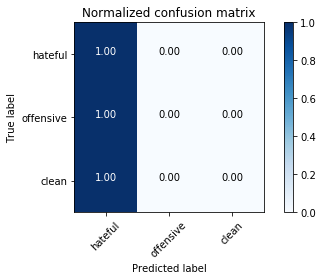

In [30]:
import itertools
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['hateful', 'offensive', 'clean'], normalize=True,
                      title='Normalized confusion matrix')